In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

# Constants
rho_air = 1.25  # kg/m^3 density of air at sea level
L_v = 2.5e6  # J/kg from UCLA-LES documentation
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_water = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
g = 9.81  # m/s^2 acceleration due to gravity

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        if var_name in ['l']:
            data = data
        if var_name in ['q']:
            data = data
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def load_xy_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
    return x_values, y_values


def calculate_temperature(theta_l, p, q_l):
    """Calculate temperature from theta_l, pressure, and liquid water mixing ratio using iterative method."""
    # Compute Exner function
    kappa = R_d / c_p
    exner = (p / p_0) ** kappa
    
    # Initialize T
    T = theta_l * exner
    
    # Iteratively solve for T
    for _ in range(10):  # Adjust number of iterations as needed
        exponent = (L_v * q_l) / (c_p * T)
        theta = theta_l * np.exp(exponent)
        T = theta * exner
    
    return T


def calculate_density(T, p, q_v, q_l):
    """Calculate air density from temperature, pressure, and mixing ratios."""
    # Virtual temperature
    T_v = T * (1 + 0.61 * q_v - q_l)
    
    # Air density
    rho = p / (R_d * T_v)
    
    return rho


def calculate_buoyancy(density, cloud_mask, g):
    """Calculate buoyancy using the density difference."""
    # Calculate the mean density of the environment (outside clouds) at each level
    env_density = np.where(cloud_mask, np.nan, density)
    env_density_mean = np.nanmean(env_density, axis=(1, 2), keepdims=True)
    
    # Avoid division by zero
    env_density_mean = np.where(env_density_mean == 0, np.nan, env_density_mean)
    
    # Calculate buoyancy
    buoyancy = g * (env_density_mean - density) / env_density_mean
    
    return buoyancy


# Specify the timestep to analyze
timestep = 35

# Load the data
theta_l_data = load_data_all_levels(t_file, 't', timestep)
p_data = load_data_all_levels(p_file, 'p', timestep)
q_t_data = load_data_all_levels(q_file, 'q', timestep)
q_l_data = load_data_all_levels(l_file, 'l', timestep)
q_v_data = q_t_data - q_l_data
w_data = load_data_all_levels(w_file, 'w', timestep)

# Load the x and y coordinate values
x_values, y_values = load_xy_values(t_file)

# Calculate temperature and density
#T_data = calculate_temperature(theta_l_data, p_data, q_t_data, q_l_data, q_v_data)
T_data = calculate_temperature(theta_l_data, p_data, q_l_data)
density_data = calculate_density(T_data, p_data, q_l_data, q_v_data)

# Define cloud mask based on liquid water content threshold
cloud_threshold = 10e-6
cloud_mask = q_l_data > cloud_threshold

# Calculate buoyancy
buoyancy_data = calculate_buoyancy(density_data, cloud_mask, g)

zt_values = load_zt_values(l_file)
# Plot the buoyancy at a random height level as a heatmap
random_height_level = 30
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(f'Buoyancy at height {zt_values[random_height_level]}')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
cax = ax.imshow(buoyancy_data[random_height_level, :, :], cmap='jet', origin='lower',
                extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])
colorbar = fig.colorbar(cax, ax=ax, label='Buoyancy (m/s^2)')

# Set the color bar limits to be the same
vmin, vmax = cax.get_clim()

# Define the region to magnify
x_start_idx, x_end_idx = 40, 155
y_start_idx, y_end_idx = 195, 260

x_start, x_end = x_values[x_start_idx], x_values[x_end_idx]
y_start, y_end = y_values[y_start_idx], y_values[y_end_idx]

# Plot the magnified buoyancy area below the main plot
axins = inset_axes(ax, width="100%", height="50%", loc='lower center', borderpad=-27.0)
axins.imshow(buoyancy_data[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='jet', origin='lower',
             vmin=vmin, vmax=vmax, extent=[x_start, x_end, y_start, y_end])
axins.set_xlabel('X (m) (Magnified)')
axins.set_ylabel('Y (m) (Magnified)')

# Draw the black line at the cloud edges on the inset plot
cloud_edges = (cloud_mask[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx])
axins.contour(cloud_edges, colors='black', linewidths=0.5, origin='lower', extent=[x_start, x_end, y_start, y_end])

# Draw the white square on the main plot
rect = patches.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, linewidth=2, edgecolor='green', facecolor='none', linestyle="--")
ax.add_patch(rect)

# Get the corners of the white square in data coordinates
corners_main = [(x_start, y_start), (x_end, y_start)]

# Get the corners of the magnified plot in axes coordinates (0, 1)
corners_inset = [(0, 1), (1, 1)]

# Convert the inset corners from axes coordinates to display coordinates
fig.canvas.draw()
trans_inset = axins.transAxes + fig.transFigure.inverted()
corners_inset_disp = trans_inset.transform(corners_inset)

# Convert the main corners from data coordinates to display coordinates
trans_main = ax.transData + fig.transFigure.inverted()
corners_main_disp = trans_main.transform(corners_main)

# Draw lines connecting the main plot to the magnified plot
for (x_main, y_main), (x_inset, y_inset) in zip(corners_main_disp, corners_inset_disp):
    line = plt.Line2D(
        [x_main, x_inset],
        [y_main, y_inset],
        transform=fig.transFigure,
        color="green", linestyle="--", linewidth=2
    )
    fig.lines.append(line)

# Additional plots for the magnified region
fig, (ax2, ax3, ax4) = plt.subplots(3, 1, figsize=(10, 24))

# Liquid Water Content
ax2.set_title(f'Liquid Water Content (Magnified) at height {zt_values[random_height_level]}')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
cax2 = ax2.imshow(q_l_data[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='Blues', origin='lower',
                  extent=[x_start, x_end, y_start, y_end])
colorbar2 = fig.colorbar(cax2, ax=ax2, label='Liquid Water Content (kg/m^3)')
ax2.contour(cloud_edges, colors='black', linewidths=0.5, origin='lower', extent=[x_start, x_end, y_start, y_end])

# Temperature
ax3.set_title(f'Temperature (Magnified) at height {zt_values[random_height_level]}')
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
cax3 = ax3.imshow(T_data[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='RdYlBu_r', origin='lower',
                  extent=[x_start, x_end, y_start, y_end])
colorbar3 = fig.colorbar(cax3, ax=ax3, label='Temperature (K)')
ax3.contour(cloud_edges, colors='black', linewidths=0.5, origin='lower', extent=[x_start, x_end, y_start, y_end])

# Vertical Velocity
ax4.set_title(f'Vertical Velocity (Magnified) at height {zt_values[random_height_level]}')
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
cax4 = ax4.imshow(w_data[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='RdBu_r', origin='lower',
                  extent=[x_start, x_end, y_start, y_end])
colorbar4 = fig.colorbar(cax4, ax=ax4, label='Vertical Velocity (m/s)')
ax4.contour(cloud_edges, colors='black', linewidths=0.5, origin='lower', extent=[x_start, x_end, y_start, y_end])


# Additional plot for theta_l (Potential Temperature)
fig, ax5 = plt.subplots(figsize=(10, 8))
ax5.set_title(f'Liquid water potential Temperature (Magnified) at height {zt_values[random_height_level]}')
ax5.set_xlabel('X (m)')
ax5.set_ylabel('Y (m)')
cax5 = ax5.imshow(theta_l_data[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='viridis', origin='lower',
                  extent=[x_start, x_end, y_start, y_end])
colorbar5 = fig.colorbar(cax5, ax=ax5, label='Potential Temperature (K)')
ax5.contour(cloud_edges, colors='black', linewidths=0.5, origin='lower', extent=[x_start, x_end, y_start, y_end])

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

# Constants
rho_air = 1.25  # kg/m^3 density of air at sea level
L_v = 2.5 * 10e5  # J/kg from UCLA-LES documentation
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_water = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
g = 9.81  # m/s^2 acceleration due to gravity

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        if var_name in ['l', 'q']:
            data = data / 1000.0
    return data

def load_xy_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
    return x_values, y_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_water)
    return rho

def calculate_buoyancy_virtual(t_file, q_file, l_file, cloud_mask, timestep, g):
    """
    Calculate buoyancy using the virtual potential temperature approach, with theta_ref calculated at timestep 1.
    """
    theta_l = load_data_all_levels(t_file, 't', timestep)
    q_t = load_data_all_levels(q_file, 'q', timestep)
    q_l = load_data_all_levels(l_file, 'l', timestep)
    q_v = q_t - q_l

    # Calculate virtual potential temperature for the current timestep
    theta_v = theta_l * (1 + 0.61 * q_v - q_l)

    # Load data for timestep 1 to calculate the reference virtual potential temperature
    theta_l_initial = load_data_all_levels(t_file, 't', 0)  # Timestep 1 (index 0)
    q_t_initial = load_data_all_levels(q_file, 'q', 0)
    q_l_initial = load_data_all_levels(l_file, 'l', 0)
    q_v_initial = q_t_initial - q_l_initial

    # Calculate virtual potential temperature for timestep 1 (reference state)
    theta_ref = theta_l_initial * (1 + 0.61 * q_v_initial - q_l_initial)

    # Compute the mean theta_ref for each vertical level (mean over horizontal dimensions)
    theta_ref_mean = np.mean(theta_ref, axis=(1, 2))  # Mean for each level

    # Now calculate the buoyancy using virtual potential temperature and reference from timestep 1
    buoyancy = np.zeros_like(theta_v)
    for z in range(theta_v.shape[0]):
        buoyancy[z, :, :] = g * (theta_v[z, :, :] - theta_ref_mean[z]) / theta_ref_mean[z]
    
    return buoyancy

def calculate_buoyancy(density, cloud_mask, g):
    """Calculate buoyancy using the corrected equation based on density."""
    buoyancy = np.zeros_like(density)
    for z in range(density.shape[0]):
        # Calculate the mean density of the environment (outside clouds)
        env_density_mean = np.mean(density[z, ~cloud_mask[z, :, :]])
        
        # Ensure that the environment density is valid
        if np.isnan(env_density_mean):
            continue
        
        # Calculate buoyancy for each point in the field
        buoyancy[z, :, :] = g * (env_density_mean - density[z, :, :]) / env_density_mean
    
    return buoyancy

# Specify the timestep to analyze
timestep = 35

# Load the data
theta_l_data = load_data_all_levels(t_file, 't', timestep)
p_data = load_data_all_levels(p_file, 'p', timestep)
q_t_data = load_data_all_levels(q_file, 'q', timestep)
q_l_data = load_data_all_levels(l_file, 'l', timestep)
q_v_data = q_t_data - q_l_data

# Load the x and y coordinate values
x_values, y_values = load_xy_values(t_file)

# Calculate temperature and density
T_data = calculate_temperature(theta_l_data, p_data, q_t_data, q_l_data, q_v_data)
density_data = calculate_density(T_data, p_data, q_l_data, q_v_data)

# Define cloud mask based on liquid water content threshold
cloud_threshold = 10e-9
cloud_mask = q_l_data > cloud_threshold

# Calculate buoyancy using both methods
buoyancy_virtual = calculate_buoyancy_virtual(t_file, q_file, l_file, cloud_mask, timestep, g)
buoyancy_old = calculate_buoyancy(density_data, cloud_mask, g)

# Calculate the difference between the two buoyancy calculations
buoyancy_difference = buoyancy_virtual - buoyancy_old

# Plot the difference at a random height level as a heatmap
random_height_level = 40
fig, ax = plt.subplots(figsize=(12, 10))  # Increase figure size to allow more room
ax.set_title(f'Buoyancy Difference at height level {random_height_level}')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
cax = ax.imshow(buoyancy_difference[random_height_level, :, :], cmap='coolwarm', origin='lower',
                extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])
colorbar = fig.colorbar(cax, ax=ax, label='Buoyancy Difference (m/s^2)')

# Define the region to magnify
x_start_idx, x_end_idx = 40, 155
y_start_idx, y_end_idx = 195, 260
x_start, x_end = x_values[x_start_idx], x_values[x_end_idx]
y_start, y_end = y_values[y_start_idx], y_values[y_end_idx]

# Plot the magnified buoyancy difference area
axins = inset_axes(ax, width="40%", height="30%", loc='upper right', borderpad=3.0)  # Change position to 'upper right'
axins.imshow(buoyancy_difference[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='coolwarm', origin='lower',
             extent=[x_start, x_end, y_start, y_end])
axins.set_xlabel('X (m) (Magnified)')
axins.set_ylabel('Y (m) (Magnified)')

# Draw the black line at the cloud edges on the inset plot
cloud_edges = (cloud_mask[random_height_level, y_start_idx:y_end_idx, x_start_idx:x_end_idx])
axins.contour(cloud_edges, colors='black', linewidths=0.5, origin='lower', extent=[x_start, x_end, y_start, y_end])

# Draw the green rectangle on the main plot
rect = patches.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, linewidth=2, edgecolor='green', facecolor='none', linestyle="--")
ax.add_patch(rect)

# Save the figure as a PDF with tight bounding box to avoid clipping
#plt.tight_layout()
#plt.savefig('buoyancy_difference_plot_fixed_position.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Constants
rho_air = 1.25  # kg/m^3 density of air at sea level
L_v = 2.5 * 10e5  # J/kg from UCLA-LES documentation
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_water = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
g = 9.81  # m/s^2 acceleration due to gravity

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        if var_name in ['l', 'q']:
            data = data / 1000.0
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def load_xy_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
    return x_values, y_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_water)
    return rho

def calculate_buoyancy(density, cloud_mask, g):
    """Calculate buoyancy using the corrected equation."""
    buoyancy = np.zeros_like(density)
    for z in range(density.shape[0]):
        # Calculate the mean density of the environment (outside clouds)
        env_density_mean = np.mean(density[z, ~cloud_mask[z, :, :]])
        
        # Ensure that the environment density is valid
        if np.isnan(env_density_mean):
            continue
        
        # Calculate buoyancy for each point in the field
        buoyancy[z, :, :] = g * (env_density_mean - density[z, :, :]) / env_density_mean
    
    return buoyancy

# Specify the timestep to analyze
timestep = 35

# Load the data
theta_l_data = load_data_all_levels(t_file, 't', timestep)
p_data = load_data_all_levels(p_file, 'p', timestep)
q_t_data = load_data_all_levels(q_file, 'q', timestep)
q_l_data = load_data_all_levels(l_file, 'l', timestep)
q_v_data = q_t_data - q_l_data
w_data = load_data_all_levels(w_file, 'w', timestep)

# Load the x and y coordinate values
x_values, y_values = load_xy_values(t_file)

# Calculate temperature and density
T_data = calculate_temperature(theta_l_data, p_data, q_t_data, q_l_data, q_v_data)
density_data = calculate_density(T_data, p_data, q_l_data, q_v_data)

# Define cloud mask based on liquid water content threshold
cloud_threshold = 10e-9
cloud_mask = q_l_data > cloud_threshold

# Calculate buoyancy
buoyancy_data = calculate_buoyancy(density_data, cloud_mask, g)

zt_values = load_zt_values(l_file)

# Define the region to magnify
x_start_idx, x_end_idx = 40, 155
y_start_idx, y_end_idx = 195, 260

x_start, x_end = x_values[x_start_idx], x_values[x_end_idx]
y_start, y_end = y_values[y_start_idx], y_values[y_end_idx]

# Create a 2x2 plot layout (removing the liquid water plot)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Buoyancy
axes[0, 0].set_title(f'Buoyancy (Magnified) at height {zt_values[40]}')
cax0 = axes[0, 0].imshow(buoyancy_data[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='jet', origin='lower',
                         extent=[x_start, x_end, y_start, y_end])
plt.colorbar(cax0, ax=axes[0, 0], label='Buoyancy (m/s^2)')
axes[0, 0].contour(cloud_mask[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], levels=[0.5], colors='black', linewidths=1)

# Temperature
axes[0, 1].set_title(f'Temperature (Magnified) at height {zt_values[40]}')
cax1 = axes[0, 1].imshow(T_data[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='RdYlBu_r', origin='lower',
                         extent=[x_start, x_end, y_start, y_end])
plt.colorbar(cax1, ax=axes[0, 1], label='Temperature (K)')
axes[0, 1].contour(cloud_mask[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], levels=[0.5], colors='black', linewidths=1)

# Vertical Velocity
axes[1, 0].set_title(f'Vertical Velocity (Magnified) at height {zt_values[40]}')
cax2 = axes[1, 0].imshow(w_data[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='RdBu_r', origin='lower',
                         extent=[x_start, x_end, y_start, y_end])
plt.colorbar(cax2, ax=axes[1, 0], label='Vertical Velocity (m/s)')
axes[1, 0].contour(cloud_mask[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], levels=[0.5], colors='black', linewidths=1)

# Liquid Water Potential Temperature
axes[1, 1].set_title(f'Liquid Water Potential Temperature (Magnified) at height {zt_values[40]}')
cax3 = axes[1, 1].imshow(theta_l_data[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], cmap='viridis', origin='lower',
                         extent=[x_start, x_end, y_start, y_end])
plt.colorbar(cax3, ax=axes[1, 1], label='Potential Temperature (K)')
axes[1, 1].contour(cloud_mask[40, y_start_idx:y_end_idx, x_start_idx:x_end_idx], levels=[0.5], colors='black', linewidths=1)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Constants
g = 9.81  # m/s^2 acceleration due to gravity
cloud_threshold = 1e-8  # kg/kg (10e-9)

# File paths (update to your own file paths)
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        if var_name in ['l', 'q']:
            data = data / 1000.0  # Convert from g/kg to kg/kg
    return data

def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

def calculate_buoyancy_virtual(t_file, q_file, l_file, timestep, g):
    """
    Calculate buoyancy using the virtual potential temperature approach,
    with theta_ref calculated at timestep 1.
    """
    # Load data at the current timestep
    theta_l = load_data_all_levels(t_file, 't', timestep)
    q_t = load_data_all_levels(q_file, 'q', timestep)
    q_l = load_data_all_levels(l_file, 'l', timestep)
    q_v = q_t - q_l

    # Calculate virtual potential temperature for the current timestep
    theta_v = theta_l * (1 + 0.61 * q_v - q_l)

    # Load data for timestep 1 to calculate the reference virtual potential temperature
    theta_l_initial = load_data_all_levels(t_file, 't', 0)  # Timestep 1 (index 0)
    q_t_initial = load_data_all_levels(q_file, 'q', 0)
    q_l_initial = load_data_all_levels(l_file, 'l', 0)
    q_v_initial = q_t_initial - q_l_initial

    # Calculate virtual potential temperature for timestep 1 (reference state)
    theta_ref = theta_l_initial * (1 + 0.61 * q_v_initial - q_l_initial)

    # Compute the mean theta_ref for each vertical level (mean over horizontal dimensions)
    theta_ref_mean = np.mean(theta_ref, axis=(1, 2))  # Mean for each level

    # Now calculate the buoyancy using virtual potential temperature and reference from timestep 1
    buoyancy = np.zeros_like(theta_v)
    for z in range(theta_v.shape[0]):
        buoyancy[z, :, :] = g * (theta_v[z, :, :] - theta_ref_mean[z]) / theta_ref_mean[z]
    
    return buoyancy

# Specify the timestep to analyze
timestep = 35

# Load the data
theta_l_data = load_data_all_levels(t_file, 't', timestep)
q_t_data = load_data_all_levels(q_file, 'q', timestep)
q_l_data = load_data_all_levels(l_file, 'l', timestep)
q_v_data = q_t_data - q_l_data
w_data = load_data_all_levels(w_file, 'w', timestep)
x_values, y_values, z_values = load_coordinate_values(t_file)

# Calculate cloud mask based on liquid water content threshold
cloud_mask = q_l_data > cloud_threshold

# Calculate buoyancy using virtual potential temperature approach
buoyancy_data = calculate_buoyancy_virtual(t_file, q_file, l_file, timestep, g)

# Select the vertical level to plot (e.g., level 40)
random_height_level = 30
height = z_values[random_height_level]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
variables = [w_data, theta_l_data, buoyancy_data, theta_l_data * (1 + 0.61 * q_v_data - q_l_data)]  # Vertical velocity, theta_l, buoyancy, temperature
titles = ['Vertical Velocity', 'Liquid Water Potential Temperature', 'Buoyancy', 'Temperature']
cmaps = ['RdBu_r', 'viridis', 'RdYlBu_r', 'RdYlBu_r']
labels = ['Vertical Velocity (m/s)', 'Theta_l (K)', 'Buoyancy (m/s^2)', 'Temperature (K)']

# For each variable, plot the data
for ax, var, title, cmap, label in zip(axs.flat, variables, titles, cmaps, labels):
    im = ax.imshow(var[random_height_level, :, :], cmap=cmap, origin='lower',
                   extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])
    ax.set_title(f'{title} at height {height:.2f} m')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    # Overlay the cloud edges
    cloud_edges = cloud_mask[random_height_level, :, :]
    ax.contour(cloud_edges, levels=[0.5], colors='black', linewidths=0.5,
               extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]], origin='lower')
    fig.colorbar(im, ax=ax, label=label)

plt.tight_layout()
plt.show()


# Using UCLA-LES definition of liquid water potential temperature


## Brent's method
Because the relationship between temperature and liquid water potential temperature is such that temperature cannot be expressed from the equatoion, I use Brent's method (root finding algorithm) to calculate T. 

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import brentq  # Root-finding method
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

# Constants
rho_air = 1.25  # kg/m^3 density of air at sea level
L_v = 2.5e6  # J/kg from UCLA-LES documentation (corrected value)
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_water = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
g = 9.81  # m/s^2 acceleration due to gravity

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'  # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'  # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'  # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'  # Liquid water potential temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'  # Pressure

# Function to load data
def load_data(filename, var_name, timestep, level):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, level, :, :]  # Extract data for the timestep and level
        if var_name in ['l', 'q']:
            data = data / 1000.0  # Convert from g/kg to kg/kg
    return data

# Load coordinate values (assuming coordinates are the same in all files)
def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

# Load data for timestep 35 and level 40
timestep = 35
level = 40  # Zero-based index; adjust if necessary

# Load variables
theta_l = load_data(t_file, 't', timestep, level)  # Liquid water potential temperature
q_l = load_data(l_file, 'l', timestep, level)      # Liquid water mixing ratio
q_t = load_data(q_file, 'q', timestep, level)      # Total water mixing ratio
p = load_data(p_file, 'p', timestep, level)  # Pressure in Pa (assuming p is in hPa)

# Load vertical velocity for plotting
w = load_data(w_file, 'w', timestep, level)

# Load coordinates
x_values, y_values, z_values = load_coordinate_values(t_file)

# Compute the Exner function π
pi = (p / p_0) ** (R_d / c_p)

# Prepare arrays for T and buoyancy
T = np.zeros_like(theta_l)

# Function to solve for T at each grid point
def compute_temperature(theta_l_point, q_l_point, pi_point):
    if q_l_point == 0:
        # When q_l is zero, compute T directly
        T_solution = theta_l_point / pi_point
    else:
        # Define the function whose root we want to find
        def f(T_point):
            return theta_l_point - T_point * pi_point * np.exp(- (q_l_point * L_v) / (c_p * T_point))
        # Provide an initial guess
        T_guess = theta_l_point / pi_point
        # Set dynamic bounds around the initial guess
        T_min = T_guess * 0.5
        T_max = T_guess * 1.5
        # Check if f(T_min) and f(T_max) have opposite signs
        f_T_min = f(T_min)
        f_T_max = f(T_max)
        if f_T_min * f_T_max > 0:
            # Expand the interval if necessary
            T_min = T_guess * 0.1
            T_max = T_guess * 10.0
            f_T_min = f(T_min)
            f_T_max = f(T_max)
            if f_T_min * f_T_max > 0:
                # If still not bracketing a root, use the initial guess
                return T_guess
        try:
            # Use brentq method to find the root
            T_solution = brentq(f, T_min, T_max)
        except ValueError:
            # If brentq fails, use the initial guess
            T_solution = T_guess
    return T_solution



# Vectorize the compute_temperature function for efficiency
vectorized_compute_temperature = np.vectorize(compute_temperature)  # Use compute_temperature, not compute_temperature_newton

# Compute temperature T at each grid point
T = vectorized_compute_temperature(theta_l, q_l, pi)

# Ensure T is of float type
T = T.astype(float)  # Convert the resulting array to float if necessary

# Compute virtual potential temperature θ_v
theta = theta_l + (L_v * q_l) / (c_p)  # Potential temperature θ
R_v_over_R_d = R_v / R_d
theta_v = theta * (1 + (R_v_over_R_d - 1) * q_t - R_v_over_R_d * q_l)

# For buoyancy calculation, we need a reference θ_v
# Compute mean θ_v over horizontal dimensions for level 40
theta_v_mean = np.mean(theta_v)

# Compute buoyancy
buoyancy = g * (theta_v - theta_v_mean) / theta_v_mean

# Apply liquid water threshold to distinguish cloudy areas
cloud_threshold = 1e-8  # kg/kg
cloudy_mask = q_l >= cloud_threshold

# Prepare plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot vertical velocity
im0 = axs[0, 0].imshow(w, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[0, 0].set_title('Vertical Velocity (m/s)')
fig.colorbar(im0, ax=axs[0, 0])

# Plot liquid water potential temperature
im1 = axs[0, 1].imshow(theta_l, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[0, 1].set_title('Liquid Water Potential Temperature (K)')
fig.colorbar(im1, ax=axs[0, 1])

# Plot buoyancy
im2 = axs[1, 0].imshow(buoyancy, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[1, 0].set_title('Buoyancy (m/s²)')
fig.colorbar(im2, ax=axs[1, 0])

# Plot temperature
im3 = axs[1, 1].imshow(T, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[1, 1].set_title('Temperature (K)')
fig.colorbar(im3, ax=axs[1, 1])

# Highlight cloudy areas on the plots
for ax in axs.flat:
    ax.contour(cloudy_mask, levels=[0.5], colors='white', linewidths=0.5, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])

plt.tight_layout()
plt.show()


## Testing suggested different equations to see what happens. 

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import brentq  # Root-finding method
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

# Constants
rho_air = 1.25  # kg/m^3 density of air at sea level
L_v = 2.5e6  # J/kg from UCLA-LES documentation (corrected value)
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_water = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
g = 9.81  # m/s^2 acceleration due to gravity

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'  # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'  # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'  # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'  # Liquid water potential temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'  # Pressure

# Function to load data
def load_data(filename, var_name, timestep, level):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, level, :, :]  # Extract data for the timestep and level
        if var_name in ['l', 'q']:
            data = data / 1000.0  # Convert from g/kg to kg/kg
    return data

# Load coordinate values (assuming coordinates are the same in all files)
def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

# Load data for timestep 35 and level 40
timestep = 35
level = 40  # Zero-based index; adjust if necessary

# Load variables
theta_l = load_data(t_file, 't', timestep, level)  # Liquid water potential temperature
q_l = load_data(l_file, 'l', timestep, level)      # Liquid water mixing ratio
q_t = load_data(q_file, 'q', timestep, level)      # Total water mixing ratio
p = load_data(p_file, 'p', timestep, level)  # Pressure in Pa (assuming p is in hPa)

# Load vertical velocity for plotting
w = load_data(w_file, 'w', timestep, level)

# Load coordinates
x_values, y_values, z_values = load_coordinate_values(t_file)

# Compute the Exner function π
pi = (p / p_0) ** (R_d / c_p)

# Prepare arrays for T and buoyancy
T = np.zeros_like(theta_l)

# Function to solve for T at each grid point
def compute_temperature(theta_l_point, q_l_point, pi_point):
    if q_l_point == 0:
        # When q_l is zero, compute T directly
        T_solution = theta_l_point * pi_point

    else:
        # Define the function whose root we want to find
        def f(T_point):
            return T_point * np.exp(- (q_l_point * L_v) / (c_p * T_point)) - theta_l_point * pi_point
        # Provide an initial guess
        T_guess = theta_l_point / pi_point
        # Set dynamic bounds around the initial guess
        T_min = T_guess * 0.5
        T_max = T_guess * 1.5
        # Check if f(T_min) and f(T_max) have opposite signs
        f_T_min = f(T_min)
        f_T_max = f(T_max)
        if f_T_min * f_T_max > 0:
            # Expand the interval if necessary
            T_min = T_guess * 0.1
            T_max = T_guess * 10.0
            f_T_min = f(T_min)
            f_T_max = f(T_max)
            if f_T_min * f_T_max > 0:
                # If still not bracketing a root, use the initial guess
                return T_guess
        try:
            # Use brentq method to find the root
            T_solution = brentq(f, T_min, T_max)
        except ValueError:
            # If brentq fails, use the initial guess
            T_solution = T_guess
    return T_solution



# Vectorize the compute_temperature function for efficiency
vectorized_compute_temperature = np.vectorize(compute_temperature)  # Use compute_temperature, not compute_temperature_newton

# Compute temperature T at each grid point
T = vectorized_compute_temperature(theta_l, q_l, pi)

# Ensure T is of float type
T = T.astype(float)  # Convert the resulting array to float if necessary

# Compute virtual potential temperature θ_v
theta = theta_l + (L_v * q_l) / (c_p)  # Potential temperature θ
R_v_over_R_d = R_v / R_d
theta_v = theta * (1 + (R_v_over_R_d - 1) * q_t - R_v_over_R_d * q_l)

# For buoyancy calculation, we need a reference θ_v
# Compute mean θ_v over horizontal dimensions for level 40
theta_v_mean = np.mean(theta_v)

# Compute buoyancy
buoyancy = g * (theta_v - theta_v_mean) / theta_v_mean

# Apply liquid water threshold to distinguish cloudy areas
cloud_threshold = 1e-8  # kg/kg
cloudy_mask = q_l >= cloud_threshold

# Prepare plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot vertical velocity
im0 = axs[0, 0].imshow(w, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[0, 0].set_title('Vertical Velocity (m/s)')
fig.colorbar(im0, ax=axs[0, 0])

# Plot liquid water potential temperature
im1 = axs[0, 1].imshow(theta_l, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[0, 1].set_title('Liquid Water Potential Temperature (K)')
fig.colorbar(im1, ax=axs[0, 1])

# Plot buoyancy
im2 = axs[1, 0].imshow(buoyancy, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[1, 0].set_title('Buoyancy (m/s²)')
fig.colorbar(im2, ax=axs[1, 0])

# Plot temperature
im3 = axs[1, 1].imshow(T, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[1, 1].set_title('Temperature (K)')
fig.colorbar(im3, ax=axs[1, 1])

# Highlight cloudy areas on the plots
for ax in axs.flat:
    ax.contour(cloudy_mask, levels=[0.5], colors='white', linewidths=0.5, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])

plt.tight_layout()
plt.show()


In [ ]:
# Define the region to magnify
x_start_idx, x_end_idx = 40, 155
y_start_idx, y_end_idx = 195, 260

# Slice the temperature data for the magnified region
T_magnified = T[y_start_idx:y_end_idx, x_start_idx:x_end_idx]

# Slice the x and y coordinate values for the magnified region
x_values_magnified = x_values[x_start_idx:x_end_idx]
y_values_magnified = y_values[y_start_idx:y_end_idx]

# Plot the magnified region for temperature
plt.figure(figsize=(8, 6))
im = plt.imshow(T_magnified, origin='lower', cmap='RdYlBu_r', extent=[x_values_magnified.min(), x_values_magnified.max(), y_values_magnified.min(), y_values_magnified.max()])
plt.title('Magnified Temperature (K)')
plt.colorbar(im, label='Temperature (K)')
plt.tight_layout()
plt.show()

## Newton-Raphson method


In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import brentq  # Root-finding method
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

# Constants
rho_air = 1.25  # kg/m^3 density of air at sea level
L_v = 2.5e6  # J/kg from UCLA-LES documentation (corrected value)
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_water = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
g = 9.81  # m/s^2 acceleration due to gravity

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'  # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'  # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'  # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'  # Liquid water potential temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'  # Pressure

# Function to load data
def load_data(filename, var_name, timestep, level):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, level, :, :]  # Extract data for the timestep and level
        if var_name in ['l', 'q']:
            data = data / 1000.0  # Convert from g/kg to kg/kg
    return data

# Load coordinate values (assuming coordinates are the same in all files)
def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

# Load data for timestep 35 and level 40
timestep = 35
level = 40  # Zero-based index; adjust if necessary

# Load variables
theta_l = load_data(t_file, 't', timestep, level)  # Liquid water potential temperature
q_l = load_data(l_file, 'l', timestep, level)      # Liquid water mixing ratio
q_t = load_data(q_file, 'q', timestep, level)      # Total water mixing ratio
p = load_data(p_file, 'p', timestep, level)  # Pressure in Pa (assuming p is in hPa)

# Load vertical velocity for plotting
w = load_data(w_file, 'w', timestep, level)

# Load coordinates
x_values, y_values, z_values = load_coordinate_values(t_file)

# Compute the Exner function π
pi = (p / p_0) ** (R_d / c_p)

# Prepare arrays for T and buoyancy
T = np.zeros_like(theta_l)


def compute_temperature_newton(theta_l_point, q_l_point, pi_point, tol=1e-6, max_iter=500):
    """
    Solve for temperature using the Newton-Raphson method.
    
    Parameters:
    - theta_l_point: Liquid water potential temperature at a specific grid point.
    - q_l_point: Liquid water mixing ratio at the same grid point.
    - pi_point: Exner function at that grid point.
    - tol: Tolerance for convergence (optional).
    - max_iter: Maximum number of iterations (optional).
    
    Returns:
    - T_solution: Computed temperature value at the grid point.
    """
    
    if q_l_point == 0:
        # When q_l is zero, compute T directly
        return theta_l_point / pi_point
    
    else:
        # Define the function whose root we want to find
        def f(T_point):
            return theta_l_point - T_point * pi_point * np.exp(- (q_l_point * L_v) / (c_p * T_point))
        
        # Define the derivative of the function with respect to T
        def f_prime(T_point):
            exp_term = np.exp(- (q_l_point * L_v) / (c_p * T_point))
            term1 = -pi_point * exp_term  # First part
            term2 = pi_point * exp_term * (q_l_point * L_v) / (c_p * T_point**2)  # Second part
            return term1 + term2
        
        # Initial guess for T
        T_guess = theta_l_point / pi_point
        
        # Perform Newton-Raphson iteration
        T_solution = T_guess
        for iteration in range(max_iter):
            # Evaluate function and its derivative
            f_value = f(T_solution)
            f_prime_value = f_prime(T_solution)
            
            # If the derivative is too small, break the loop (avoid division by near-zero)
            if abs(f_prime_value) < 1e-10:
                break
            
            # Update the solution using Newton-Raphson update rule
            T_new = T_solution - f_value / f_prime_value
            
            # Check for convergence
            if abs(T_new - T_solution) < tol:
                return T_new  # Converged solution
            
            # Update the solution for the next iteration
            T_solution = T_new
        
        # If we reach here, it means the method did not converge within the max_iter limit
        print(f"Warning: Newton-Raphson did not converge after {max_iter} iterations at some grid points.")
        
        # Return a fallback value (e.g., the initial guess)
        return T_guess  # You can return a fallback value like the initial guess








# Vectorize the compute_temperature function for efficiency
vectorized_compute_temperature = np.vectorize(compute_temperature_newton)

# Compute temperature T at each grid point
T = vectorized_compute_temperature(theta_l, q_l, pi)

# Ensure T is of float type
T = T.astype(float)  # Convert the resulting array to float if necessary

# Compute virtual potential temperature θ_v
theta = theta_l + (L_v * q_l) / (c_p)  # Potential temperature θ
R_v_over_R_d = R_v / R_d
theta_v = theta * (1 + (R_v_over_R_d - 1) * q_t - R_v_over_R_d * q_l)

# For buoyancy calculation, we need a reference θ_v
# Compute mean θ_v over horizontal dimensions for level 40
theta_v_mean = np.mean(theta_v)

# Compute buoyancy
buoyancy = g * (theta_v - theta_v_mean) / theta_v_mean

# Apply liquid water threshold to distinguish cloudy areas
cloud_threshold = 1e-8  # kg/kg
cloudy_mask = q_l >= cloud_threshold

# Prepare plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot vertical velocity
im0 = axs[0, 0].imshow(w, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[0, 0].set_title('Vertical Velocity (m/s)')
fig.colorbar(im0, ax=axs[0, 0])

# Plot liquid water potential temperature
im1 = axs[0, 1].imshow(theta_l, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[0, 1].set_title('Liquid Water Potential Temperature (K)')
fig.colorbar(im1, ax=axs[0, 1])

# Plot buoyancy
im2 = axs[1, 0].imshow(buoyancy, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[1, 0].set_title('Buoyancy (m/s²)')
fig.colorbar(im2, ax=axs[1, 0])

# Plot temperature
im3 = axs[1, 1].imshow(T, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axs[1, 1].set_title('Temperature (K)')
fig.colorbar(im3, ax=axs[1, 1])

# Highlight cloudy areas on the plots
for ax in axs.flat:
    ax.contour(cloudy_mask, levels=[0.5], colors='white', linewidths=0.5, origin='lower', extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])

plt.tight_layout()
plt.show()


In [ ]:
# Define the region to magnify
x_start_idx, x_end_idx = 40, 155
y_start_idx, y_end_idx = 195, 260

# Slice the temperature data for the magnified region
T_magnified = T[y_start_idx:y_end_idx, x_start_idx:x_end_idx]

# Slice the x and y coordinate values for the magnified region
x_values_magnified = x_values[x_start_idx:x_end_idx]
y_values_magnified = y_values[y_start_idx:y_end_idx]

# Plot the magnified region for temperature
plt.figure(figsize=(8, 6))
im = plt.imshow(T_magnified, origin='lower', cmap='RdYlBu_r', extent=[x_values_magnified.min(), x_values_magnified.max(), y_values_magnified.min(), y_values_magnified.max()])
plt.title('Magnified Temperature (K)')
plt.colorbar(im, label='Temperature (K)')
plt.tight_layout()
plt.show()

# Tuesday October 1st

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Constants
p0 = 100000       # Reference pressure in Pa
R_d = 287         # Gas constant for dry air in J/(kg·K)
c_p = 1004        # Specific heat at constant pressure in J/(kg·K)
kappa = R_d / c_p
L_v = 2.5e6       # Latent heat of vaporization in J/kg

# File paths (update these paths to point to your data files)
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'  # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'  # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'  # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'  # Liquid water potential temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'  # Pressure

# Specify the timestep and level you want to plot
timestep = 35  # Adjust as per your data (zero-based index)
level = 45     # Adjust as per your data (zero-based index)

# Function to load data for a specific timestep and level
def load_data(filename, var_name, timestep, level):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, level, :, :]  # Extract data for the timestep and level
        if var_name in ['l', 'q']:
            data = data  # Convert from g/kg to kg/kg
    return data

# Load variables for the specified timestep and level
theta_l = load_data(t_file, 't', timestep, level)  # Liquid water potential temperature (K)
q_l = load_data(l_file, 'l', timestep, level)      # Liquid water mixing ratio (kg/kg)
p = load_data(p_file, 'p', timestep, level)        # Pressure (Pa)

# Compute the Exner function π
pi = (p / p0) ** kappa
pi[pi == 0] = np.nan  # Avoid division by zero

# Compute potential temperature θ
theta = theta_l + (L_v / c_p) * (q_l / pi)

# Load coordinate values
def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

x_values, y_values, z_values = load_coordinate_values(t_file)  # Use any of your files

# Get the height corresponding to the selected level
height = z_values[level]
print(f"Plotting data at height level {level} corresponding to {height} meters.")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set common color limits for both plots
vmin = min(theta.min(), theta_l.min())
vmax = max(theta.max(), theta_l.max())

# Plot potential temperature θ
im1 = axes[0].imshow(theta, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
                     vmin=vmin, vmax=vmax)
axes[0].set_title(f'Potential Temperature θ\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
fig.colorbar(im1, ax=axes[0], orientation='vertical', label='θ (K)')

# Plot liquid water potential temperature θ_l
im2 = axes[1].imshow(theta_l, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
                     vmin=vmin, vmax=vmax)
axes[1].set_title(f'Liquid Water Potential Temperature θₗ\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
fig.colorbar(im2, ax=axes[1], orientation='vertical', label='θₗ (K)')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('full_field_new_temp.pdf', format='pdf')
plt.show()


In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Constants
p0 = 100000       # Reference pressure in Pa
R_d = 287         # Gas constant for dry air in J/(kg·K)
c_p = 1004        # Specific heat at constant pressure in J/(kg·K)
kappa = R_d / c_p
L_v = 2.5e6       # Latent heat of vaporization in J/kg

# File paths (update these paths to point to your data files)
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'  # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'  # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'  # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'  # Liquid water potential temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'  # Pressure

# Specify the timestep and level you want to plot
timestep = 28  # Adjust as per your data (zero-based index)
level = 40     # Adjust as per your data (zero-based index)

# Function to load data for a specific timestep and level
def load_data(filename, var_name, timestep, level):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, level, :, :]  # Extract data for the timestep and level
        if var_name in ['l', 'q']:
            data = data  # Convert from g/kg to kg/kg
    return data

# Load variables for the specified timestep and level
theta_l = load_data(t_file, 't', timestep, level)  # Liquid water potential temperature (K)
q_l = load_data(l_file, 'l', timestep, level)      # Liquid water mixing ratio (kg/kg)
p = load_data(p_file, 'p', timestep, level)        # Pressure (Pa)
w = load_data(w_file, 'w', timestep, level)        # Vertical velocity (m/s)

# Compute the Exner function π
pi = (p / p0) ** kappa
pi[pi == 0] = np.nan  # Avoid division by zero

# Compute potential temperature θ
theta = theta_l + (L_v / c_p) * (q_l / pi)

# Compute normal temperature T
T = theta * pi

# Load coordinate values
def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

x_values, y_values, z_values = load_coordinate_values(t_file)  # Use any of your files

# Get the height corresponding to the selected level
height = z_values[level]
print(f"Plotting data at height level {level} corresponding to {height} meters.")

# Threshold for liquid water mixing ratio (r_l)
rl_threshold = 1e-8  # kg/kg

# Create a mask for where liquid water mixing ratio is above the threshold
with nc.Dataset(l_file) as ds:
    r_l = ds['l'][timestep, level, :, :] / 1000.0  # Convert from g/kg to kg/kg
liquid_water_mask = r_l > rl_threshold

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot 1: Potential Temperature θ
im0 = axes[0].imshow(theta, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axes[0].set_title(f'Potential Temperature θ\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
cbar0 = fig.colorbar(im0, ax=axes[0], orientation='vertical', label='θ (K)')
# Add contour for liquid water mixing ratio
axes[0].contour(x_values, y_values, liquid_water_mask, levels=[0.5], colors='white', linewidths=1)

# Plot 2: Liquid Water Potential Temperature θₗ
im1 = axes[1].imshow(theta_l, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axes[1].set_title(f'Liquid Water Potential Temperature θₗ\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
cbar1 = fig.colorbar(im1, ax=axes[1], orientation='vertical', label='θₗ (K)')
axes[1].contour(x_values, y_values, liquid_water_mask, levels=[0.5], colors='white', linewidths=1)

# Plot 3: Temperature T
im2 = axes[2].imshow(T, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axes[2].set_title(f'Temperature T\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[2].set_xlabel('X Coordinate')
axes[2].set_ylabel('Y Coordinate')
cbar2 = fig.colorbar(im2, ax=axes[2], orientation='vertical', label='T (K)')
axes[2].contour(x_values, y_values, liquid_water_mask, levels=[0.5], colors='white', linewidths=1)

# Plot 4: Vertical Velocity w
im3 = axes[3].imshow(w, origin='lower', cmap='RdBu_r', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axes[3].set_title(f'Vertical Velocity w\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[3].set_xlabel('X Coordinate')
axes[3].set_ylabel('Y Coordinate')
cbar3 = fig.colorbar(im3, ax=axes[3], orientation='vertical', label='w (m/s)')
axes[3].contour(x_values, y_values, liquid_water_mask, levels=[0.5], colors='white', linewidths=1)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Constants
p0 = 100000       # Reference pressure in Pa
R_d = 287         # Gas constant for dry air in J/(kg·K)
c_p = 1004        # Specific heat at constant pressure in J/(kg·K)
kappa = R_d / c_p
L_v = 2.5e6       # Latent heat of vaporization in J/kg

# File paths (update these paths to point to your data files)
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'  # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'  # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'  # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'  # Liquid water potential temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'  # Pressure

# Specify the timestep and level you want to plot
timestep = 28  # Adjust as per your data (zero-based index)
level = 40     # Adjust as per your data (zero-based index)

# Function to load data for a specific timestep and level
def load_data(filename, var_name, timestep, level):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, level, :, :]  # Extract data for the timestep and level
        if var_name in ['l', 'q']:
            data = data  # Convert from g/kg to kg/kg
    return data

# Load variables for the specified timestep and level
theta_l = load_data(t_file, 't', timestep, level)  # Liquid water potential temperature (K)
q_l = load_data(l_file, 'l', timestep, level)      # Liquid water mixing ratio (kg/kg)
p = load_data(p_file, 'p', timestep, level)        # Pressure (Pa)

# Compute the Exner function π
pi = (p / p0) ** kappa
pi[pi == 0] = np.nan  # Avoid division by zero

# Compute potential temperature θ
theta = theta_l + (L_v / c_p) * (q_l / pi)

# Compute normal temperature T
T = theta * pi

# Load coordinate values
def load_coordinate_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
        z_values = ds['zt'][:]
    return x_values, y_values, z_values

x_values, y_values, z_values = load_coordinate_values(t_file)  # Use any of your files

# Get the height corresponding to the selected level
height = z_values[level]
print(f"Plotting data at height level {level} corresponding to {height} meters.")

# Threshold for liquid water mixing ratio (r_l)
rl_threshold = 1e-8  # kg/kg

# Create a mask for where liquid water mixing ratio is above the threshold
with nc.Dataset(l_file) as ds:
    r_l = ds['l'][timestep, level, :, :]  # Convert from g/kg to kg/kg
liquid_water_mask = r_l > rl_threshold

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot 1: Liquid Water Potential Temperature θₗ
im0 = axes[0].imshow(theta_l, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axes[0].set_title(f'Liquid Water Potential Temperature θₗ\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
cbar0 = fig.colorbar(im0, ax=axes[0], orientation='vertical', label='θₗ (K)')
# Add contour for liquid water mixing ratio
axes[0].contour(x_values, y_values, liquid_water_mask, levels=[0.5], colors='black', linewidths=1)

# Plot 2: Temperature T
im1 = axes[1].imshow(T, origin='lower', cmap='viridis', aspect='auto',
                     extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
axes[1].set_title(f'Temperature T\nTime: {timestep}, Level: {level}, Height: {height:.2f} m')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
cbar1 = fig.colorbar(im1, ax=axes[1], orientation='vertical', label='T (K)')
axes[1].contour(x_values, y_values, liquid_water_mask, levels=[0.5], colors='black', linewidths=1)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('new_temp.pdf', format='pdf')
plt.show()


# New Temp: 5th October

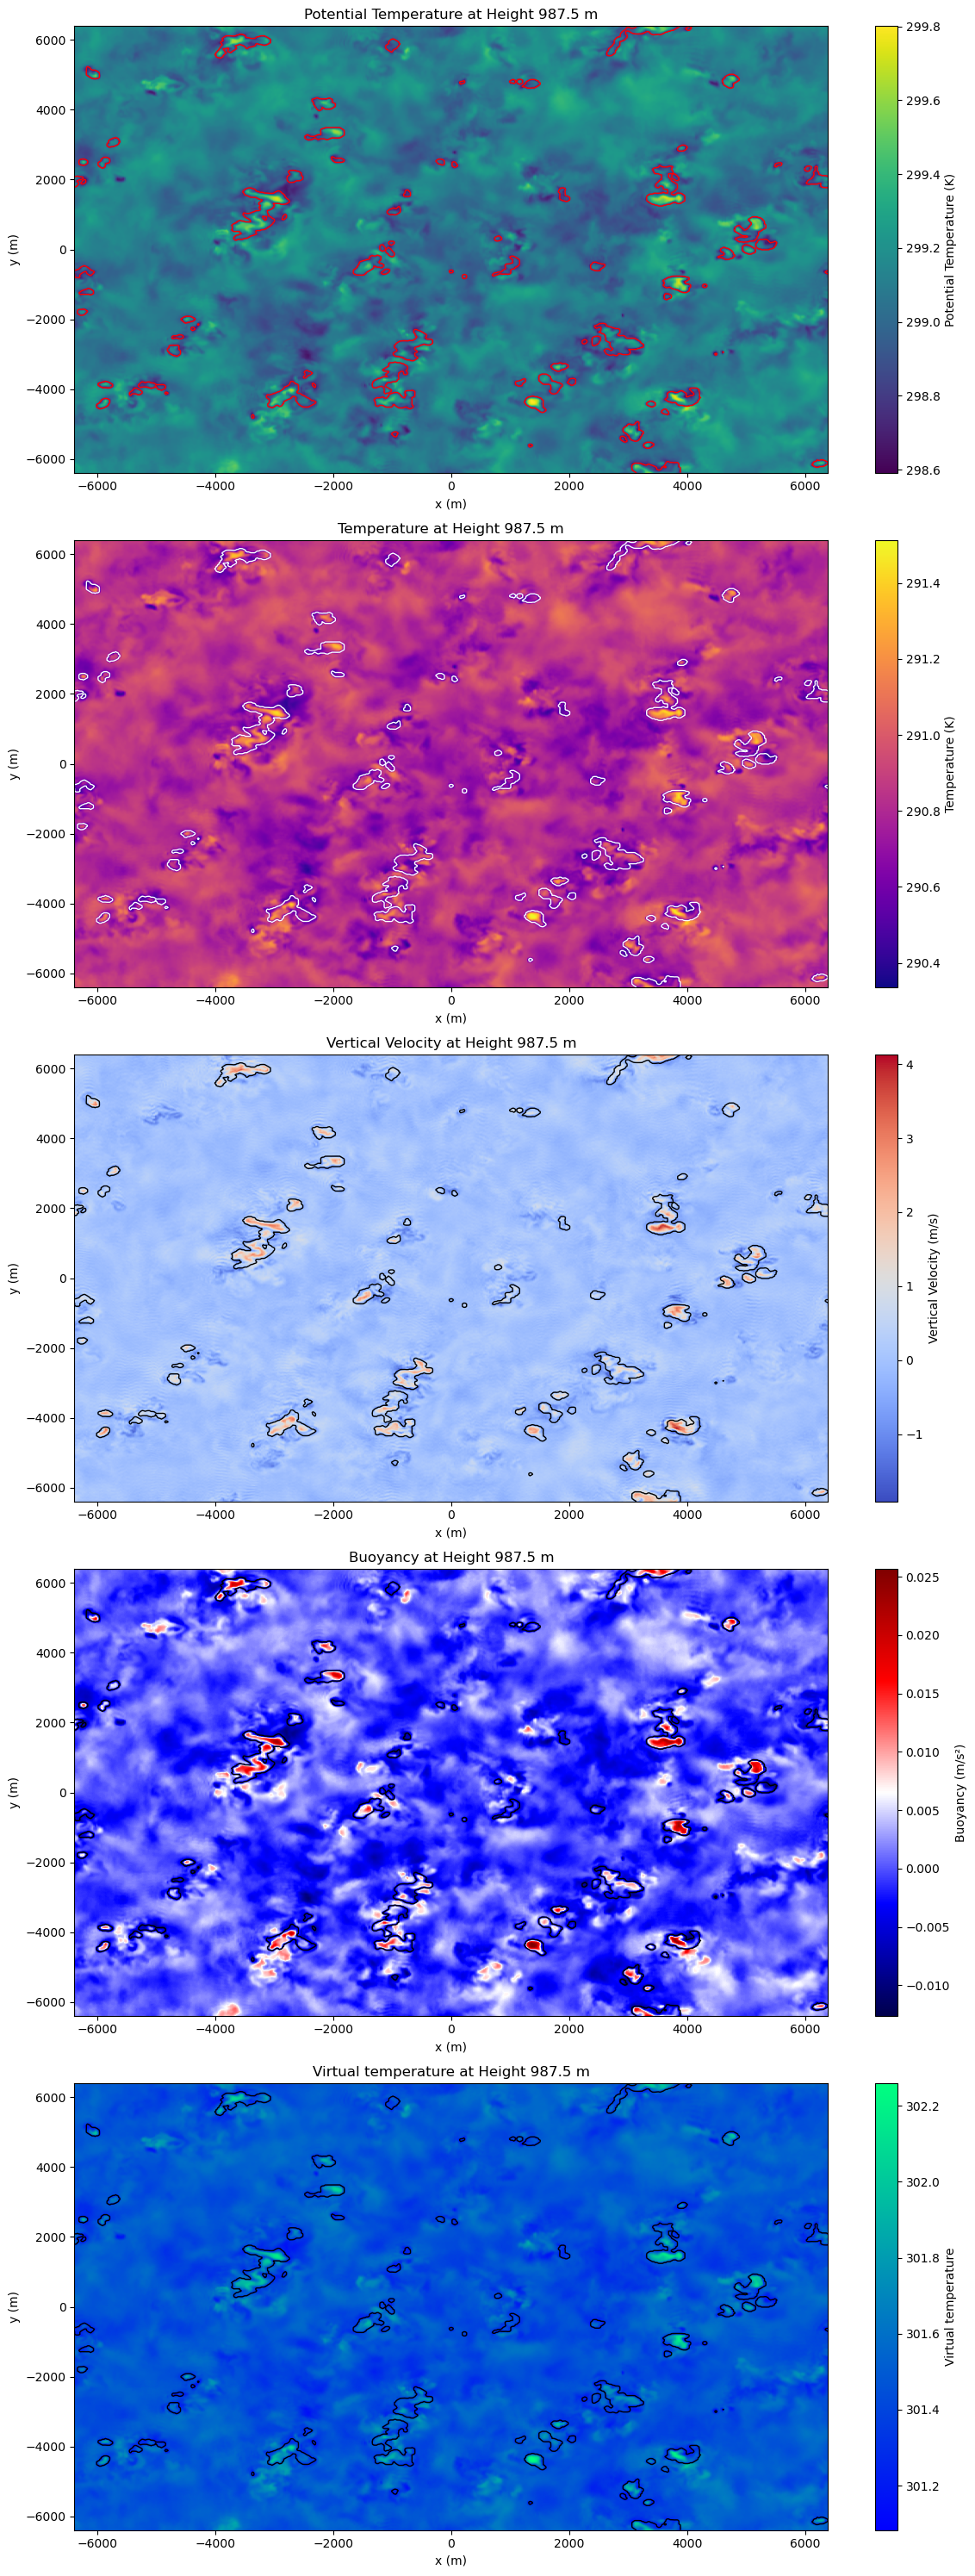

In [20]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Constants
L_v = 2.5e6          # J/kg latent heat of vaporization
c_p = 1005.0         # J/kg/K specific heat capacity of dry air
R_v = 461.5
R_d = 287.05         # J/kg/K gas constant for dry air
p_0 = 100000.0       # Pa standard pressure at sea level
g = 9.81             # m/s^2 acceleration due to gravity
ep2 = R_v/R_d -1     # Dimensionless constant for water vapor

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def load_xy_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
    return x_values, y_values

# File paths (Update these paths to match your file locations)
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

timestep = 20       # Specify the timestep you want to extract
height_index = 40   # Index of the height level you want to extract

# Load data (including vertical velocity)
t = load_data_all_levels(t_file, 't', timestep)
q = load_data_all_levels(q_file, 'q', timestep)
l = load_data_all_levels(l_file, 'l', timestep)
p = load_data_all_levels(p_file, 'p', timestep)
w = load_data_all_levels(w_file, 'w', timestep)  # Load vertical velocity

# Load zt, x, y values
zt = load_zt_values(p_file)  # Assuming zt is the same in all files
x_values, y_values = load_xy_values(p_file)

# Select the height level
t_level = t[height_index, :, :]
q_level = q[height_index, :, :]
l_level = l[height_index, :, :]
p_level = p[height_index, :, :]
w_level = w[height_index, :, :]  # Vertical velocity at the specified height

# Compute q_v (Vapor Mixing Ratio)
q_v = q_level - l_level

# Compute θ_l (Liquid Water Potential Temperature)
theta_l = t_level

# Exner function
cpr = R_d / c_p
exner = (p_level / p_0) ** cpr

# Compute temperature T
T = theta_l * exner + (L_v * l_level) / c_p

# Compute full potential temperature θ
theta = T / exner

# Define the liquid water threshold
lw_threshold = 1e-5

# Create a mask for non-cloudy areas
non_cloudy_mask = l_level < lw_threshold




# Compute virtual temperature
theta_v = theta * (1 + ep2 * q_v - l_level)

# Compute reference virtual temperature over non-cloudy areas
if np.any(non_cloudy_mask):
    theta_v_0 = np.mean(theta_v[non_cloudy_mask])
else:
    # Fallback: Use the mean of theta over the entire level
    theta_v_0 = np.mean(theta_v)
    print("Warning: No non-cloudy areas found at this level. Using mean theta over the entire level.")


# Compute Buoyancy
B =  g * ((theta_v / theta_v_0) - 1)


# # Old Compute Virtual Potential Temperature and Buoyancy
# theta_v = theta * (1 + ep2 * q_v)
# B = 0.5 * g * ((theta_v / theta_0) - 1 - l_level)


# Create a figure with four subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 30))  # 5 rows, 1 column

# Plotting Potential Temperature θ
im0 = axs[0].imshow(
    theta.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='viridis'
)
fig.colorbar(im0, ax=axs[0], label='Potential Temperature (K)')
axs[0].set_title(f'Potential Temperature at Height {zt[height_index]:.1f} m')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')

# Overlay contour lines for l_level > lw_threshold
contour_levels = [lw_threshold]
cs0_contour = axs[0].contour(
    x_values, y_values, l_level.T, levels=contour_levels, colors='red', linewidths=1
)

# Plotting Temperature T
im1 = axs[1].imshow(
    T.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='plasma'
)
fig.colorbar(im1, ax=axs[1], label='Temperature (K)')
axs[1].set_title(f'Temperature at Height {zt[height_index]:.1f} m')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')

# Overlay contour lines for l_level > lw_threshold
cs1_contour = axs[1].contour(
    x_values, y_values, l_level.T, levels=contour_levels, colors='white', linewidths=1
)

# Plotting Vertical Velocity w
im2 = axs[2].imshow(
    w_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='coolwarm'
)
fig.colorbar(im2, ax=axs[2], label='Vertical Velocity (m/s)')
axs[2].set_title(f'Vertical Velocity at Height {zt[height_index]:.1f} m')
axs[2].set_xlabel('x (m)')
axs[2].set_ylabel('y (m)')

# Overlay contour lines for l_level > lw_threshold
cs2_contour = axs[2].contour(
    x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1
)

# Plotting Buoyancy B
im3 = axs[3].imshow(
    B.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='seismic'
)
fig.colorbar(im3, ax=axs[3], label='Buoyancy (m/s²)')
axs[3].set_title(f'Buoyancy at Height {zt[height_index]:.1f} m')
axs[3].set_xlabel('x (m)')
axs[3].set_ylabel('y (m)')

# Overlay contour lines for l_level > lw_threshold
cs3_contour = axs[3].contour(
    x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1
)

# Plotting virtual temperature
im4 = axs[4].imshow(
    theta_v.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='winter'
)
fig.colorbar(im4, ax=axs[4], label='Virtual temperature')
axs[4].set_title(f'Virtual temperature at Height {zt[height_index]:.1f} m')
axs[4].set_xlabel('x (m)')
axs[4].set_ylabel('y (m)')

# Overlay contour lines for l_level > lw_threshold
cs4_contour = axs[4].contour(
    x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1
)

plt.tight_layout()
plt.savefig('new_temp_and_buoyanc.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [7]:

print (f"total water mixing ratio max is {q_level.max()} ")
print (f"total water mixing ratio min is {q_level.min()} ")
print (f"Liquid water mixing ratio max is {l_level.max()} ")
print (f"Liquid water mixing ratio min is {l_level.min()} ")

total water mixing ratio max is 0.015599255450069904 
total water mixing ratio min is 0.012409121729433537 
Liquid water mixing ratio max is 0.0007964169490151107 
Liquid water mixing ratio min is 0.0 


In [18]:
print(f"Min θ: {theta.min()}, Max θ: {theta.max()}")
print(f"Reference θ_0: {theta_0}")
print(f"Min θ_v: {theta_v.min()}, Max θ_v: {theta_v.max()}")
print(f"Min Buoyancy B: {B.min()}, Max Buoyancy B: {B.max()}")

Min θ: 298.5914001464844, Max θ: 299.8004455566406
Reference θ_0: 299.09606350234895
Min θ_v: 301.0829772949219, Max θ_v: 302.25872802734375
Min Buoyancy B: -0.006305052898824215, Max Buoyancy B: 0.012824698351323605
